# Sky with the Moon Up

* https://desi.lbl.gov/trac/wiki/CommissioningCommissioningPlanning/commishdata#NightSky
* https://portal.nersc.gov/project/desi/collab/nightwatch/kpno/20191112/exposures.html
* http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2019-11-12/nightsum.html

**Data**  
* /global/projecta/projectdirs/desi/spectro/redux/daily/exposures/20191112  
* /global/projecta/projectdirs/desi/spectro/redux/daily/exposures/20191112
* Exposures 27337-27396

**Data Model**  
* https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures/NIGHT/EXPID/sky-CAMERA-EXPID.html

John Moustakas

In [1]:
import os, sys
import numpy as np
import fitsio

In [2]:
import astropy.units as u
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy.io import fits

In [3]:
import desispec.io
import desimodel.io

In [4]:
import speclite
import specsim.atmosphere
import specsim.simulator
from desietcimg.db import DB, Exposures

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sns.set(context='talk', style='ticks', font_scale=1.1)
%matplotlib inline

In [7]:
topdir = os.getenv('DESI_ROOT')+'/spectro'
gfadir = '/project/projectdirs/desi/users/ameisner/GFA/reduced/v0001'

#### Load the GFA filter curve.

In [136]:
def load_gfa_filter():
    if False:
        rfilt = speclite.filters.load_filter('decam2014-r')
    else:
        if False:
            filtfile = '/global/homes/a/ameisner/ci_throughput/etc/gfa_filter_transmission_DESI-1297.dat'
            filtwave, filtresp, _, _ = np.loadtxt(filtfile, unpack=True)
        else:
            filt = Table.read('/global/homes/a/ameisner/ci_throughput/etc/gfa_throughput-airmass_1.00.fits')
            filtwave, filtresp = filt['LAMBDA_NM'], filt['THROUGHPUT']
            
        filtresp[filtresp < 0] = 0
        filtresp[0] = 0
        filtresp[-1] = 0
        srt = np.argsort(filtwave)
        filtwave, filtresp = filtwave[srt] * 10, filtresp[srt]
        rfilt = speclite.filters.FilterResponse(wavelength=filtwave * u.Angstrom,
                                                response=filtresp,
                                                meta=dict(group_name='gfa', band_name='r'))
        
        return rfilt

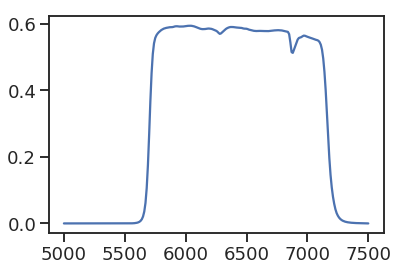

In [137]:
rfilt = load_gfa_filter()
plt.plot(rfilt.wavelength, rfilt.response)

#### Specify the night and range of GFA and spectrograph exposure IDs.

In [10]:
night = 20191112
expid_start, expid_end = 27337, 27396
expids = np.arange(expid_end - expid_start + 1) + expid_start

#### Initialize access to the online database.

https://github.com/desihub/desicmx/blob/master/analysis/gfa/DESI-Online-Database-Tutorial.ipynb

In [11]:
if not os.path.exists('db.yaml'):
    import getpass
    pw = getpass.getpass(prompt='Enter database password: ')
    with open('db.yaml', 'w') as f:
        print('host: db.replicator.dev-cattle.stable.spin.nersc.org', file=f)
        print('dbname: desi_dev', file=f)
        print('port: 60042', file=f)
        print('user: desi_reader', file=f)
        print(f'password: {pw}', file=f)
    print('Created db.yaml')

In [12]:
db = DB()
ExpInfo = Exposures(db)

In [13]:
for col in ('airmass', 'skyra', 'skydec', 'moonangl', 'moonra', 'moondec'):
    print(col, ExpInfo(27339, col))

airmass None
skyra None
skydec None
moonangl None
moonra None
moondec None


#### Read A. Meisner's reductions to get the sky background in the GFAs vs moon separation.

In [14]:
def read_gfa(night, expid, raw=False):
    sexpid = '{:08d}'.format(expid)
    rawfname = topdir+'/data/{0}/{1}/gfa-{1}.fits.fz'.format(night, sexpid)
    fname = gfadir+'/{0}/{1}/gfa-{1}_ccds.fits'.format(night, sexpid)    
    if os.path.isfile(fname):
        # get the target-moon separation
        hdr = fitsio.read_header(rawfname, ext=1)
        #print(hdr)
        
        ra, dec, moonra, moondec = hdr['SKYRA'], hdr['SKYDEC'], hdr['MOONRA'], hdr['MOONDEC']
        csky = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        cmoon = SkyCoord(ra=moonra*u.degree, dec=moondec*u.degree, frame='icrs')
        moonsep = np.array(csky.separation(cmoon).value).astype('f4') # [degree]

        #print('Reading {}'.format(fname))
        data = Table.read(fname)
        #print(data.colnames)
        
        # pack into a table
        out = Table()
        out['sky_mag_ab'] = [np.mean(data['sky_mag_ab'])]
        out['sky_mag_ab_err'] = [np.std(data['sky_mag_ab']) / np.sqrt(len(data))]
        out['moonsep'] = [moonsep]
        #out['airmass'] = [hdr['AIRMASS']]
        
        out = out[np.argsort(out['moonsep'])[::-1]]
        
        return out
    else:
        return None

In [15]:
#data = read_gfa(night, 27390)
#data

In [16]:
def gfa_sky(night):
    out = []
    for expid in expids:
        dd = read_gfa(night, expid)
        if dd is not None:
            out.append(dd)
    return vstack(out)

In [65]:
#Table(fitsio.read(os.getenv('DESI_ROOT')+'/users/ameisner/GFA/files/skymags-prelim.fits')).colnames
Table(fitsio.read(os.getenv('DESI_ROOT')+'/users/ameisner/GFA/files/skymags-prelim.with_airmass.fits')).colnames

['EXPID',
 'FLAVOR',
 'FNAME_RAW',
 'EXPTIME',
 'PROGRAM',
 'SKYRA',
 'SKYDEC',
 'NIGHT',
 'MJD',
 'EXTNAME',
 'N_BAD',
 'N_VERY_BAD',
 'N_BAD_BY_AMP',
 'N_VERY_BAD_BY_AMP',
 'ADU_PER_PIX_MEDIAN',
 'ADU_PER_PIX_S_MEDIAN',
 'ADU_PER_PIX_MEDIAN_CAMERA',
 'ADU_PER_PIX_S_MEDIAN_CAMERA',
 'FNAME_DETRENDED',
 'ADU_PER_PIX_MEDIAN_TOP',
 'ADU_PER_PIX_S_MEDIAN_TOP',
 'ADU_PER_PIX_MEDIAN_TOP_CAMERA',
 'ADU_PER_PIX_S_MEDIAN_TOP_CAMERA',
 'SKYMAG_MEDIAN',
 'SKYMAG_MEDIAN_CAMERA',
 'SKYMAG_MEDIAN_TOP',
 'SKYMAG_MEDIAN_TOP_CAMERA',
 'CONTRAST',
 'FNAME_REDUCED',
 'GCCDTEMP',
 'GCOLDTEC',
 'GFILTERT',
 'GCAMTEMP',
 'GHOTTEC',
 'GFPGAT',
 'RA_MOON_DEG',
 'DEC_MOON_DEG',
 'MOON_PHASE',
 'AIRMASS']

Read Aaron's updated GFA analysis outputs.

In [66]:
def gfa_sky_updated():
    #gfafile = os.getenv('DESI_ROOT')+'/users/ameisner/GFA/files/skymags-prelim.fits'
    gfafile = os.getenv('DESI_ROOT')+'/users/ameisner/GFA/files/skymags-prelim.with_airmass.fits'

    cat = Table(fitsio.read(gfafile, lower=True))
    cat = cat[(cat['expid'] >= expid_start) * (cat['expid'] <= expid_end)]

    ra, dec, moonra, moondec = cat['skyra'], cat['skydec'], cat['ra_moon_deg'], cat['dec_moon_deg']
    #print(moonra, moondec)
    
    csky = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    cmoon = SkyCoord(ra=moonra*u.degree, dec=moondec*u.degree, frame='icrs')
    moonsep = np.array(csky.separation(cmoon).value) # [degree]
    
    out = Table()
    out['camera'] = cat['extname']
    out['expid'] = cat['expid']
    out['airmass'] = cat['airmass']
    out['ra'] = cat['skyra']
    out['dec'] = cat['skydec']
    out['moon_phase'] = cat['moon_phase']
    out['sky_mag_ab'] = cat['skymag_median_top_camera'].astype('f4')
    #out['sky_mag_ab_err'] = [np.std(data['sky_mag_ab']) / np.sqrt(len(data))]
    out['moonsep'] = moonsep.astype('f4')
    
    out = out[np.argsort(out['moonsep'])[::-1]]
    
    return out    

In [67]:
if False:
    gfa = gfa_sky(night)
else:
    gfa = gfa_sky_updated()
gfa

camera,expid,airmass,ra,dec,moon_phase,sky_mag_ab,moonsep
bytes6,int32,float32,float64,float64,float32,float32,float32
GUIDE5,27384,1.061345,9.496729,25.49872,0.99433434,18.603962,45.05746
GUIDE2,27384,1.061345,9.496729,25.49872,0.99433434,18.578222,45.05746
GUIDE2,27383,1.059849,9.496779,25.49873,0.9943448,18.578348,45.049534
GUIDE5,27383,1.059849,9.496779,25.49873,0.9943448,18.609594,45.049534
GUIDE2,27382,1.058379,9.496829986572266,25.498741,0.9943553,18.590765,45.04158
GUIDE5,27382,1.058379,9.496829986572266,25.498741,0.9943553,18.610603,45.04158
GUIDE2,27380,1.056941,9.496879577636719,25.498751,0.99436575,18.585062,45.033653
GUIDE5,27380,1.056941,9.496879577636719,25.498751,0.99436575,18.610685,45.033653
GUIDE2,27379,1.055451,9.496958,25.49876,0.99437684,18.590044,45.025208


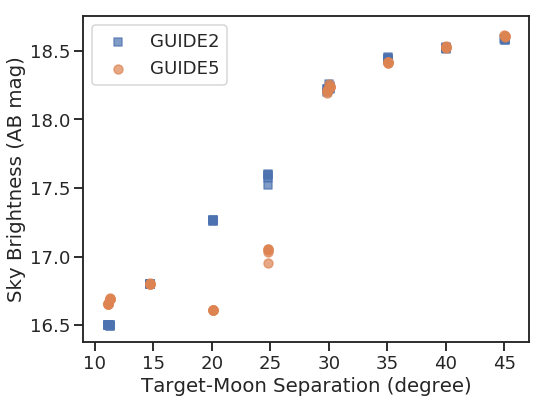

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))
for cam, mark in zip(set(gfa['camera']), ('s', 'o')):
    ww = gfa['camera'] == cam
    ax.scatter(gfa['moonsep'][ww], gfa['sky_mag_ab'][ww], 
               label=cam, marker=mark, s=80, alpha=0.7)
    #ax.invert_yaxis()
    #ax.set_ylim(17.5, 14.5)
    ax.set_xlabel('Target-Moon Separation (degree)')
    ax.set_ylabel('Sky Brightness (AB mag)')
ax.legend()

#### Read the spectroscopic reductions to get the sky spectra vs moon separation.

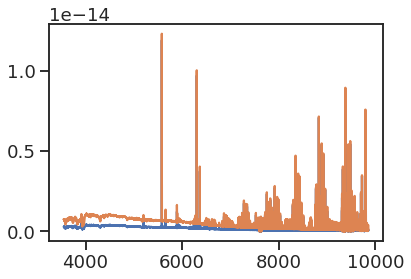

In [143]:
skymodel = specsim.simulator.Simulator('desi').atmosphere
skymodel.airmass = 1.1
skymodel.moon.moon_phase = 0.05
skymodel.moon.moon_zenith = 40 * u.deg
for moonsep in (45, 10):
    skymodel.moon.separation_angle = moonsep * u.deg
    skymodelflux = (skymodel.surface_brightness * np.pi * (0.75 * u.arcsec) ** 2).to(
        u.erg / (u.Angstrom * u.cm ** 2 * u.s))
    plt.plot(skymodel._wavelength, skymodelflux.value)

In [28]:
def read_spec(night, expid):
    sexpid = '{:08d}'.format(expid)
    datadir = topdir+'/redux/daily/exposures/{}/{}/'.format(night, sexpid)
    if os.path.isdir(datadir):
        #fr = desispec.io.read_frame('{}/frame-r3-{}.fits'.format(datadir, sexpid))
        sp = desispec.io.read_frame('{}/sframe-r3-{}.fits'.format(datadir, sexpid))
        sky = desispec.io.read_sky('{}/sky-r3-{}.fits'.format(datadir, sexpid))
        return sp, sky
        #return fr, sp, sky
    else:
        return None, None    

In [29]:
#sp, sky = read_spec(night, 27339)

In [139]:
def spec_sky():
    import astropy.time
    import astropy.coordinates
  
    # hack!
    from astropy.utils.iers import conf
    from astropy.utils import iers
    conf.auto_max_age = None  
    iers.Conf.iers_auto_url.set('ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all')    
    
    moonphase = 0.99 # from elog
    loc = astropy.coordinates.EarthLocation.of_site('Kitt Peak')
    
    # skymodel
    skymodel = specsim.simulator.Simulator('desi').atmosphere

    _rfilt = speclite.filters.FilterSequence([rfilt])
    rand = np.random.RandomState(seed=1)
    allmoonsep, meansky, stdsky, skymodelmag = [], [], [], []
    specsky, specwave = [], []
    for expid in expids:
        sp, sky = read_spec(night, expid)
        if sky is not None:
            # blarg! there's no metadata in the headers (or in the database), so
            # choose the RA, Dec, and airmass from the nearest GFA exposure.
            this = np.argmin(np.abs(gfa['expid'] - expid))
            ra, dec = gfa['ra'][this], gfa['dec'][this]
            moonphase, airmass = gfa['moon_phase'][this], gfa['airmass'][this], 
            
            # get the object-moon separation!!
            #moonsep.append(sky.header['PROGRAM'][:3])
            hdr = sky.header
            date, obstime = hdr['DATE-OBS'], hdr['TIME-OBS']
            mjd, exptime = hdr['MJD-OBS'], hdr['EXPTIME']
            
            time = astropy.time.Time(mjd, format='mjd')
            #time = astropy.time.Time(date, format='isot', scale='utc')
            moonpos = astropy.coordinates.get_moon(time, loc)
            moonra, moondec = moonpos.ra, moonpos.dec
            
            csky = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
            cmoon = SkyCoord(ra=moonra, dec=moondec, frame='icrs')
            moonsep = csky.separation(cmoon)
            allmoonsep.append(moonsep.value)
            
            moon_altaz = moonpos.transform_to(astropy.coordinates.AltAz(obstime=time, location=loc))
            moon_az = moon_altaz.az.value * u.degree
            moon_zenith = (90. - moon_altaz.alt.value) * u.degree
            
            # get the model sky brightness
            skymodel.airmass = airmass
            skymodel.moon.moon_phase = 1 - moonphase
            skymodel.moon.moon_zenith = moon_zenith
            skymodel.moon.separation_angle = moonsep
            print(skymodel.airmass, skymodel.moon.moon_phase, skymodel.moon.moon_zenith.value, 
                  skymodel.moon.separation_angle.value)
            
            skymodelflux = (skymodel.surface_brightness * np.pi * (0.75 * u.arcsec) ** 2).to(
                u.erg / (u.Angstrom * u.cm ** 2 * u.s))
            pad_skymodelflux, pad_skymodelwave = _rfilt.pad_spectrum(
                skymodelflux.value, skymodel._wavelength)
            
            #plt.plot(pad_skymodelwave, pad_skymodelflux)
            #import pdb ; pdb.set_trace()
            
            skymodel_abmags = _rfilt.get_ab_magnitudes(pad_skymodelflux, pad_skymodelwave)[rfilt.name]
            skymodelmag.append(skymodel_abmags)

            # now the data: convolve the spectrum with the r-band filter curve
            keep = sp.fibermap['OBJTYPE'] == 'SKY'
            padflux, padwave = _rfilt.pad_spectrum(sky.flux[keep, :], sky.wave, method='edge')
            abmags = _rfilt.get_ab_magnitudes(padflux, padwave)[rfilt.name]
            
            meansky.append(np.mean(abmags))
            stdsky.append(np.std(abmags) / np.sqrt(len(abmags)))
            
            # get the median spectra for this moon separation
            specwave.append(sky.wave)
            specsky.append(np.percentile(sky.flux[keep, :], axis=0, q=50))
            #q25sky = np.percentile(sky.flux[keep, :], axis=0, q=25)
            #q75sky = np.percentile(sky.flux[keep, :], axis=0, q=75)
            #these = rand.choice(keep, size=20, replace=False)
            #[plt.plot(sky.wave, sky.flux[ii, :], alpha=1.0) for ii in these]
            #plt.plot(sky.wave, medsky, alpha=0.7, color='k')            
            
    out = Table()
    out['moonsep'] = np.hstack(allmoonsep).astype('f4')
    out['meansky'] = np.hstack(meansky).astype('f4')
    out['stdsky'] = np.hstack(stdsky).astype('f4')
    out['specwave'] = specwave
    out['specsky'] = specsky
    out['skymodel'] = np.hstack(skymodelmag).astype('f4')
    
    out = out[np.argsort(out['moonsep'])[::-1]]
    
    return out

In [140]:
spec = spec_sky()
spec

1.135532 0.005206167697906494 39.02388224453785 11.524084260068705
1.078306 0.005278944969177246 37.44397902291399 15.088697925552745
1.036005 0.005337893962860107 36.06165549525979 20.416294148979837
1.014965 0.005398929119110107 34.826075024260426 25.099808777289752
1.006545 0.005457639694213867 33.444792937378146 30.15439522558452
1.011384 0.005528509616851807 32.0643339446588 35.29544976607305
1.028271 0.005585134029388428 30.897864628311616 40.254013645534165
1.058379 0.005644679069519043 29.718594928481984 45.23538267884811
1.010082 0.00571131706237793 28.438781899100626 30.25755193005937
1.037518 0.005782425403594971 27.035356300790205 11.56641078038712


moonsep,meansky,stdsky,specwave [2326],specsky [2326],skymodel
float32,float32,float32,float64,float64,float32
45.235382,-28.052639,9.732611e-06,5760.0 .. 7620.0,35.20424270629883 .. 69.00575256347656,17.713285
40.254013,-28.139944,1.0157091e-05,5760.0 .. 7620.0,38.95997619628906 .. 72.70320510864258,17.631958
35.29545,-28.265266,8.854209e-06,5760.0 .. 7620.0,41.19006156921387 .. 81.04788589477539,17.53171
30.257551,-28.426544,8.342143e-06,5760.0 .. 7620.0,52.36232376098633 .. 88.49101257324219,17.400507
30.154396,-28.439268,9.35363e-06,5760.0 .. 7620.0,51.56990432739258 .. 91.60662460327148,17.406256
25.09981,-29.097633,9.147397e-06,5760.0 .. 7620.0,86.75776290893555 .. 186.1117935180664,17.258678
20.416294,-29.355968,7.0393576e-06,5760.0 .. 7620.0,107.38399505615234 .. 235.17302703857422,17.097229
15.088698,-29.64863,8.655342e-06,5760.0 .. 7620.0,143.58824157714844 .. 316.5589599609375,16.881086
11.566411,-29.884981,7.5893536e-06,5760.0 .. 7620.0,178.16889190673828 .. 396.22503662109375,16.777075


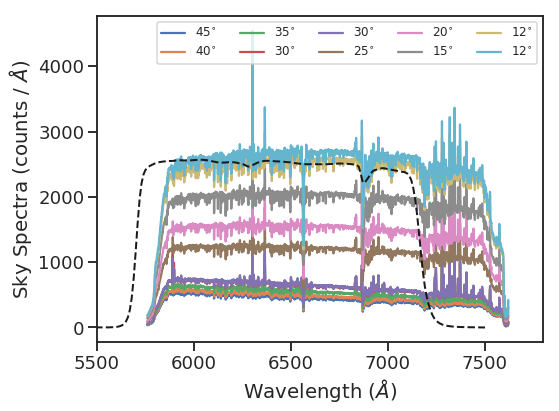

In [138]:
fig, ax = plt.subplots(figsize=(8, 6))

ref = spec['moonsep'].argmax()
#print(ref, spec['specsky'][ref])
for ss in spec:
    #print(ss['specwave'], ss['specsky'] / spec['specsky'][ref])
    ax.plot(ss['specwave'], ss['specsky'],# / spec['specsky'][0],
            label=r'{:.0f}$^{{\circ}}$'.format(ss['moonsep']))
ax.plot(rfilt.wavelength, rfilt.response / np.max(rfilt.response) * np.median(spec['specsky'][-1]),
        color='k', ls='--', lw=2)

ax.set_xlim(5500, 7800)
#ax.set_yscale('log')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Sky Spectra (counts / $\AA$)')
ax.legend(ncol=5, fontsize=12)
#ax.set_title('Night {}'.format(night))

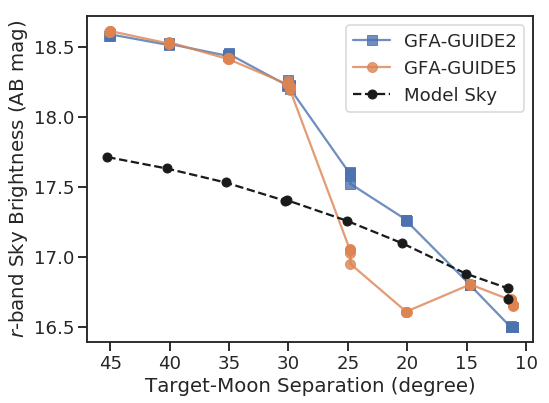

In [141]:
fig, ax = plt.subplots(figsize=(8, 6))

for cam, mark in zip(set(gfa['camera']), ('s', 'o')):
    ww = gfa['camera'] == cam
    ax.plot(gfa['moonsep'][ww], gfa['sky_mag_ab'][ww], '{}-'.format(mark),
            alpha=0.8, markersize=10, label='GFA-{}'.format(cam))

ax.plot(spec['moonsep'], spec['skymodel'], 'o--', color='k', label='Model Sky')
ax.invert_xaxis()
#ax.set_ylim(17.5, 14.5)
ax.set_xlabel('Target-Moon Separation (degree)')
ax.set_ylabel('$r$-band Sky Brightness (AB mag)')
ax.legend()

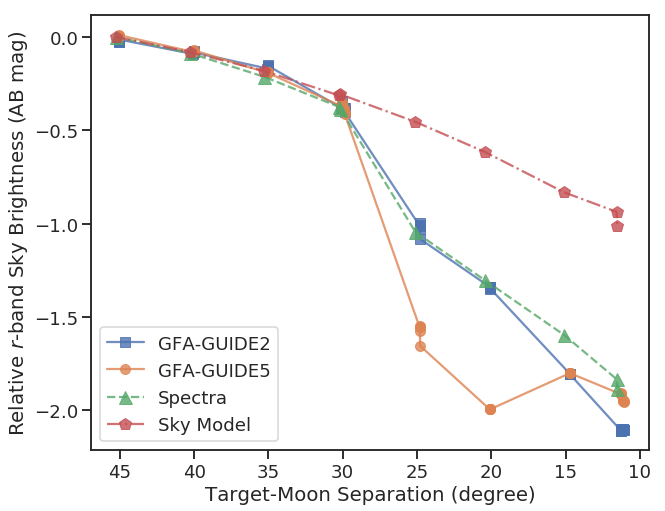

In [142]:
fig, ax = plt.subplots(figsize=(10, 8))

specref = spec['meansky'][spec['moonsep'].argmax()]

for cam, mark in zip(set(gfa['camera']), ('s', 'o')):
    ww = gfa['camera'] == cam
    gfaref = gfa['sky_mag_ab'][gfa['moonsep'].argmax()]
    ax.plot(gfa['moonsep'][ww], gfa['sky_mag_ab'][ww] - gfaref, '{}-'.format(mark),
            alpha=0.8, markersize=10, 
            label='GFA-{}'.format(cam))#, marker=mark, s=80)
#ax.scatter(gfa['moonsep'], gfa['sky_mag_ab'] - gfaref, label='GFAs')

ax.plot(spec['moonsep'], spec['meansky'] - specref, '^--', 
        alpha=0.8, markersize=13, label='Spectra')

modelref = spec['skymodel'][spec['moonsep'].argmax()]
ax.plot(spec['moonsep'], spec['skymodel'] - modelref, 'p-.', 
        alpha=0.8, markersize=13, label='Sky Model')

ax.invert_xaxis()
#ax.set_ylim(17.5, 14.5)
ax.set_xlabel('Target-Moon Separation (degree)')
ax.set_ylabel('Relative $r$-band Sky Brightness (AB mag)')
ax.legend(loc='lower left')
#ax.set_title('Night {}'.format(night))

#### Playing around

In [ ]:
import specsim.simulator
desi = specsim.simulator.Simulator('desi', num_fibers=1)
desi.instrument.fiberloss_method = 'table'
desi.simulate()

In [ ]:
plt.plot(desi.atmosphere._wavelength.value, desi.atmosphere.surface_brightness.value)
plt.xlim(5500, 8500)

In [ ]:
from astropy.coordinates import EarthLocation
loc = EarthLocation.of_site('Kitt Peak')
loc

time = astropy.time.Time(t['DATE'], format='jd')

moon_position = astropy.coordinates.get_moon(time, loc)
moon_ra = moon_position.ra.value
moon_dec = moon_position.dec.value
moon_position_altaz = moon_position.transform_to(astropy.coordinates.AltAz(obstime=time, location=location))
moon_alt = moon_position_altaz.alt.value
moon_az = moon_position_altaz.az.value

In [ ]:
EarthLocation.from_geodetic(lat='-30d10m10.78s', lon='-70d48m23.49s', height=2241.4*u.m)